# CS 203 - Assignment 11
---

**Team Number:** 13

**Members:**

- Jeet Joshi (23110148)
- Kain Harshil Shivkumar (23110151)

### Importing Dependencies

In [18]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import matplotlib.pyplot as plt

### Dataset Preparation (SST-2)

In [19]:
train_url = 'https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv'
test_url  = 'https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv'
df_train = pd.read_csv(train_url, sep='\t', header=None, names=['sentence','label'])
df_test  = pd.read_csv(test_url,  sep='\t', header=None, names=['sentence','label'])

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train['sentence'].values,
    df_train['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df_train['label'].values
)

In [21]:
max_features = 10000
vectorizer = CountVectorizer(max_features=max_features)
vectorizer.fit(X_train)
X_train_vec = vectorizer.transform(X_train).toarray()
X_val_vec   = vectorizer.transform(X_val).toarray()
X_test_vec  = vectorizer.transform(df_test['sentence'].values).toarray()

train_ds = TensorDataset(torch.from_numpy(X_train_vec).float(), torch.from_numpy(y_train).long())
val_ds   = TensorDataset(torch.from_numpy(X_val_vec).float(),   torch.from_numpy(y_val).long())
test_ds  = TensorDataset(torch.from_numpy(X_test_vec).float(), torch.from_numpy(df_test['label'].values).long())

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)
test_loader  = DataLoader(test_ds,  batch_size=64)

### MLP Model

In [22]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, num_classes, dropout_p=0.3):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_sizes:
            layers += [
                nn.Linear(prev, h),
                nn.ReLU(),
                nn.Dropout(dropout_p)
            ]
            prev = h
        layers.append(nn.Linear(prev, num_classes))  # Final output layer (logits)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=max_features, hidden_sizes=[512,256,128,64], num_classes=2)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 5293122


### Training

In [24]:
import os
import torch
import torch.optim as optim
import torch.nn as nn

device = torch.device('cpu')
model.to(device)

# Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initializing variables to track best validation accuracy
best_val_acc = 0.0
train_accs, val_accs = [], []
train_losses, val_losses = [], []

# Training loop
for epoch in range(1, 11):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

    model.eval()
    val_loss, v_correct, v_total = 0, 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits = model(Xb)
            val_loss += criterion(logits, yb).item()
            preds = logits.argmax(dim=1)
            v_correct += (preds == yb).sum().item()
            v_total += yb.size(0)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = v_correct / v_total
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc:.4f}")

    # Saving best model
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), 'checkpoint.pt')

# After training, saving the final best model to 'original.pt'
if os.path.exists('checkpoint.pt'):
    os.replace('checkpoint.pt', 'original.pt')
    print(f"Best model saved as 'original.pt' with Val Acc={best_val_acc:.4f}")

Epoch 1: Train Loss=0.5964, Train Acc=0.6606, Val Loss=0.4942, Val Acc=0.7666
Epoch 2: Train Loss=0.2657, Train Acc=0.8956, Val Loss=0.5995, Val Acc=0.7514
Epoch 3: Train Loss=0.0826, Train Acc=0.9678, Val Loss=0.7905, Val Acc=0.7710
Epoch 4: Train Loss=0.0186, Train Acc=0.9933, Val Loss=1.1143, Val Acc=0.7688
Epoch 5: Train Loss=0.0077, Train Acc=0.9978, Val Loss=1.4103, Val Acc=0.7789
Epoch 6: Train Loss=0.0027, Train Acc=0.9991, Val Loss=1.7967, Val Acc=0.7775
Epoch 7: Train Loss=0.0034, Train Acc=0.9987, Val Loss=2.1338, Val Acc=0.7493
Epoch 8: Train Loss=0.0134, Train Acc=0.9962, Val Loss=1.3698, Val Acc=0.7659
Epoch 9: Train Loss=0.0091, Train Acc=0.9973, Val Loss=1.5002, Val Acc=0.7623
Epoch 10: Train Loss=0.0026, Train Acc=0.9989, Val Loss=1.7106, Val Acc=0.7659
Best model saved as 'original.pt' with Val Acc=0.7789


### Plotting Training and Validation Accuracy and Loss

Plotting validation accuracy and loss curves


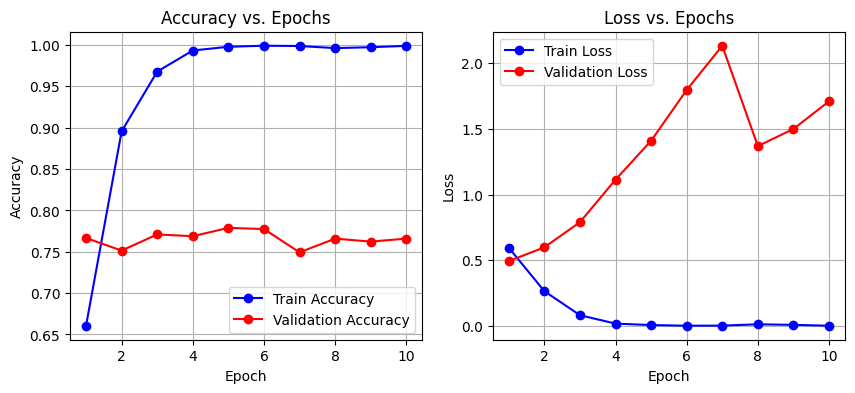

In [25]:
print("Plotting validation accuracy and loss curves")
plt.figure(figsize=(10, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_accs, 'bo-', label='Train Accuracy')
plt.plot(range(1, 11), val_accs, 'ro-', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_losses, 'bo-', label='Train Loss')
plt.plot(range(1, 11), val_losses, 'ro-', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

### Quantization & Half Precision

In [26]:
# Original model
model.load_state_dict(torch.load('original.pt'))
model.eval()

# Dynamic Quantization
quantized_model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
torch.save(quantized_model, 'quantized.pt')  # Saving entire model

# Half Precision
half_model = MLP(max_features, [512,256,128,64], 2).to(device)
half_model.load_state_dict(torch.load('original.pt'))  # Loading in FP32 first
half_model = half_model.half()  # Converting to FP16
half_model.eval()
torch.save(half_model.state_dict(), 'half.pt')

### Evaluation Function

In [27]:
def evaluate(m, loader, device, half=False, num_runs=10):
    m.to(device)
    m.eval()
    correct, total = 0, 0
    inference_times = []

    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()

            for Xb, yb in loader:
                Xb = Xb.half().to(device) if half else Xb.to(device)
                yb = yb.to(device)
                preds = m(Xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

            inference_time = (time.time() - start_time) * 1000  # Converting to milliseconds
            inference_times.append(inference_time)

    avg_inference_time = sum(inference_times) / len(inference_times)  # Average over all runs
    accuracy = (correct / total) * 100
    return accuracy, avg_inference_time

### Comparison Table

In [28]:
file_map = {'Original': 'original.pt', 'Dynamic': 'quantized.pt', 'Half': 'half.pt'}
table = []

# Original Model
acc, avg_inference_time = evaluate(model, test_loader, device)
size = os.path.getsize(file_map['Original']) / (1024 * 1024)
table.append(['Original', f"{acc:.2f}", f"{size:.2f}", f"{avg_inference_time:.2f}"])

# Quantized Model
quantized_model = torch.load('quantized.pt', map_location='cpu', weights_only=False)
acc, avg_inference_time = evaluate(quantized_model, test_loader, torch.device('cpu'))
size = os.path.getsize(file_map['Dynamic']) / (1024 * 1024)
table.append(['Dynamic', f"{acc:.2f}", f"{size:.2f}", f"{avg_inference_time:.2f}"])

# Half Model
acc, avg_inference_time = evaluate(half_model, test_loader, device, half=True)
size = os.path.getsize(file_map['Half']) / (1024 * 1024)
table.append(['Half', f"{acc:.2f}", f"{size:.2f}", f"{avg_inference_time:.2f}"])

# Printing Results
print(tabulate(table, headers=['Model', 'Acc (%)', 'Size (MB)', 'Avg Inference Time (ms)']))

Model       Acc (%)    Size (MB)    Avg Inference Time (ms)
--------  ---------  -----------  -------------------------
Original      78.53        20.2                      426.55
Dynamic       78.58         5.06                     257.2
Half          78.53        10.1                     1759.81


### Estimated Sizes from Parameters

In [29]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

estimates = [
    ('Original (FP32)', num_params * 4 / (1024*1024)),
    ('Half (FP16)',     num_params * 2 / (1024*1024)),
    ('Quantized (INT8)',num_params * 1 / (1024*1024))
]

print("Estimated Sizes (based on parameter count):")
print(tabulate(estimates, headers=["Model (Precision)", "Estimated Size (MB)"]))

Estimated Sizes (based on parameter count):
Model (Precision)      Estimated Size (MB)
-------------------  ---------------------
Original (FP32)                   20.1917
Half (FP16)                       10.0958
Quantized (INT8)                   5.04791
